In [1]:
import torch
import numpy as np

import matplotlib.pyplot as plt

from matplotlib import rc
from load_data import load_data

In [2]:
case_name = 'JetLES'

gt_ten = load_data(case_name)
gt_ten = torch.from_numpy(gt_ten).type(torch.float32)

pred_ten = torch.load(f'{case_name}_predicted_ten.pt')

print(gt_ten.shape)
print(pred_ten.shape)


Loading Data: DONE



torch.Size([1, 39, 175, 2000])
torch.Size([1, 39, 175, 2100])


In [3]:
gt_mat = gt_ten[..., :100].reshape((-1, 100))

mean_flow = gt_mat[..., :100].mean(dim = -1, keepdim = True)

U, S, VT = torch.linalg.svd(gt_mat - mean_flow, full_matrices = False)

recon = U[:,:5] @ S[:5].diag() @ VT[:5, :]

recon += mean_flow

recon = recon.reshape(gt_ten[..., :100].shape)

([<matplotlib.axis.XTick at 0x7f3490502b50>,
 [Text(1, 0, '1'),
  Text(5, 0, '5'),
  Text(10, 0, '10'),
  Text(15, 0, '15'),
  Text(20, 0, '20')])

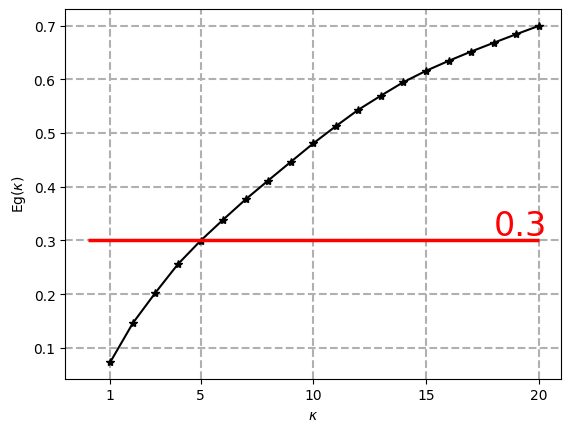

In [4]:
_ = torch.cumsum(S, dim = 0)

plt.plot(np.arange(1, 21), _[:20] / _[-1], '-*', color = 'k', linewidth = 1.5)
plt.hlines([0.3], xmin = [0.], xmax = [20.], color = "r", linewidth = 2.5)
plt.grid(True, linewidth = 1.5, linestyle = "--")
plt.text(18, 0.31, "0.3", fontsize = 24, color = "r")
plt.ylabel("Eg$(\kappa)$")
plt.xlabel("$\kappa$")
# plt.xticks([1, 10, 20, 30, 40]
plt.xticks([1, 5, 10, 15, 20])

In [5]:
diff = gt_ten.reshape((-1, 2000)) - pred_ten[..., :2000].reshape((-1, 2000))
mae = torch.linalg.norm(diff, dim = 0)

In [6]:
indices = []

for i1 in range(2000):

    if (mae[i1] == 0):

        indices = indices + [i1]

In [7]:
gt_mat = gt_ten[..., :].reshape((-1, 2000))

mean_flow = gt_mat[..., :2000].mean(dim = -1, keepdim = True)

U, S, VT = torch.linalg.svd(gt_mat - mean_flow, full_matrices = False)

recon = U[:,:30] @ S[:30].diag() @ VT[:30, :]

recon += mean_flow

recon = recon.reshape(gt_ten[..., :2000].shape)

In [8]:
_ = torch.cumsum(S, dim = 0)
_[30]/_[-1]

tensor(0.3045)

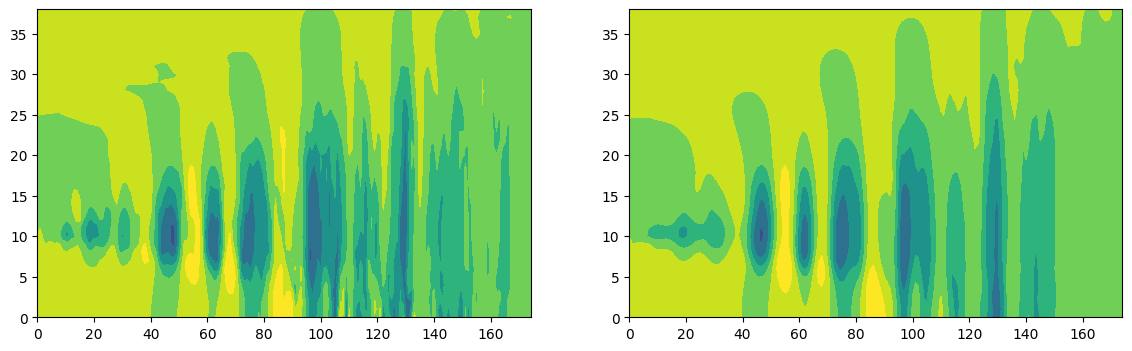

In [9]:
fig, axs = plt.subplots(1, 2, figsize = (14, 4))

vmin = gt_ten[0,:,:,1600].min()
vmax = gt_ten[0,:,:,1600].max()

axs[0].contourf(gt_ten[0,:,:,1000], vmin = vmin, vmax = vmax)
axs[1].contourf(recon[0,:,:,1000], vmin = vmin, vmax = vmax)

In [10]:
for i1 in indices:

    pred_ten[..., i1] = recon[..., i1]

In [11]:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "DejaVu Sans",
    "font.size": 24,
    'text.latex.preamble': r'\usepackage{amsfonts}',
    'text.latex.preamble': r'\usepackage{amsmath}'
})

rc('text', usetex=True)

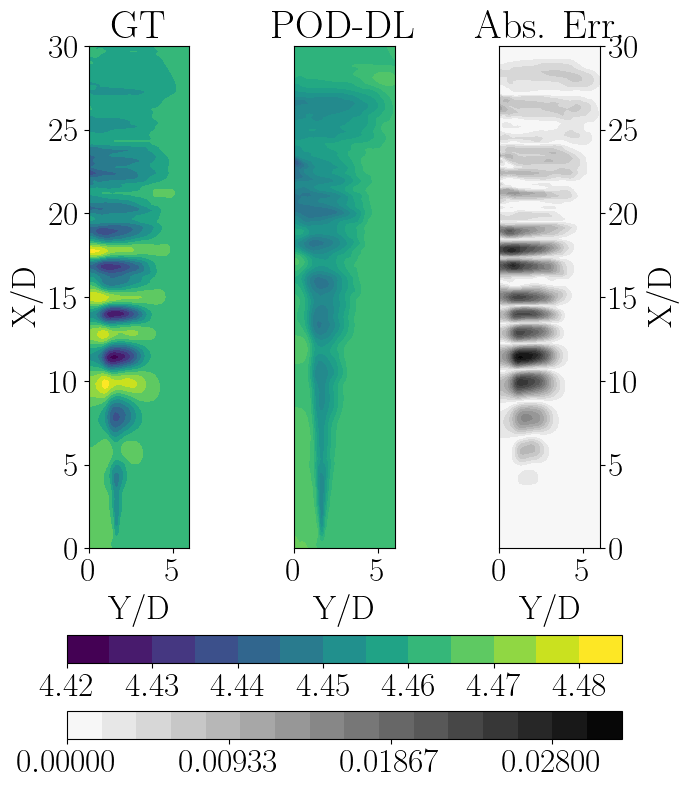

In [12]:
plt.rcParams.update({
    "font.size": 24
})

plt.close("all")

snap = 1750

x = np.linspace(0, 30, 175)
y = np.linspace(0, 6, 39)

fig, axs = plt.subplots(1, 3, figsize = (7.5, 9))

vmin = recon[0, :, :, snap].min()
vmax = recon[0, :, :, snap].max()

im = axs[0].contourf(y, x, recon[0, :, :, snap].T, 12, vmin = vmin, vmax = vmax, cmap = "viridis")
axs[0].set_title("GT")
axs[0].set_xlabel("Y/D")
axs[0].set_ylabel("X/D")

axs[0].set_aspect('equal', adjustable='box')

axs[1].contourf(y, x, pred_ten[0, :, :, snap].T, 12, vmin = vmin, vmax = vmax, cmap = "viridis")
axs[1].set_title("POD-DL")
axs[1].set_xlabel("Y/D")
axs[1].tick_params(
    left = False, 
    right = False, 
    labelleft = False, 
    labelright = False,
    labelbottom = True, 
    bottom = True
)
axs[1].set_aspect('equal', adjustable='box')

diff = (recon[0, :, :, snap] - pred_ten[0, :, :, snap]).abs()
im2 = axs[2].contourf(y, x, diff.T, 15, vmin = 0, cmap = "gray_r")
axs[2].tick_params(
    left = False, 
    right = True, 
    labelleft = False, 
    labelright = True,
    labelbottom = True, 
    bottom = True
)
axs[2].yaxis.set_label_position('right')
axs[2].set_title("Abs. Err.")
axs[2].set_xlabel("Y/D")
axs[2].set_ylabel("X/D")
axs[2].set_aspect('equal', adjustable='box')

fig.colorbar(im2, ax = axs[0:], ticks = np.linspace(0,0.028, 4), fraction = 0.04, pad = 0.07, location = 'bottom')
cbar = fig.colorbar(im, ax = axs[0:], fraction = 0.045, pad = 0.14, location = 'bottom')

# Metric 1: Quantiles

In [13]:
_ = recon.reshape((-1, 2000))

gt_median = torch.quantile(_, 0.5, dim = 0)
gt_25th = torch.quantile(_, 0.25, dim = 0)
gt_75th = torch.quantile(_, 0.75, dim = 0)

_ = pred_ten[..., :2000].reshape((-1, 2000))

pred_median = torch.quantile(_, 0.5, dim = 0)
pred_25th = torch.quantile(_, 0.25, dim = 0)
pred_75th = torch.quantile(_, 0.75, dim = 0)

del _

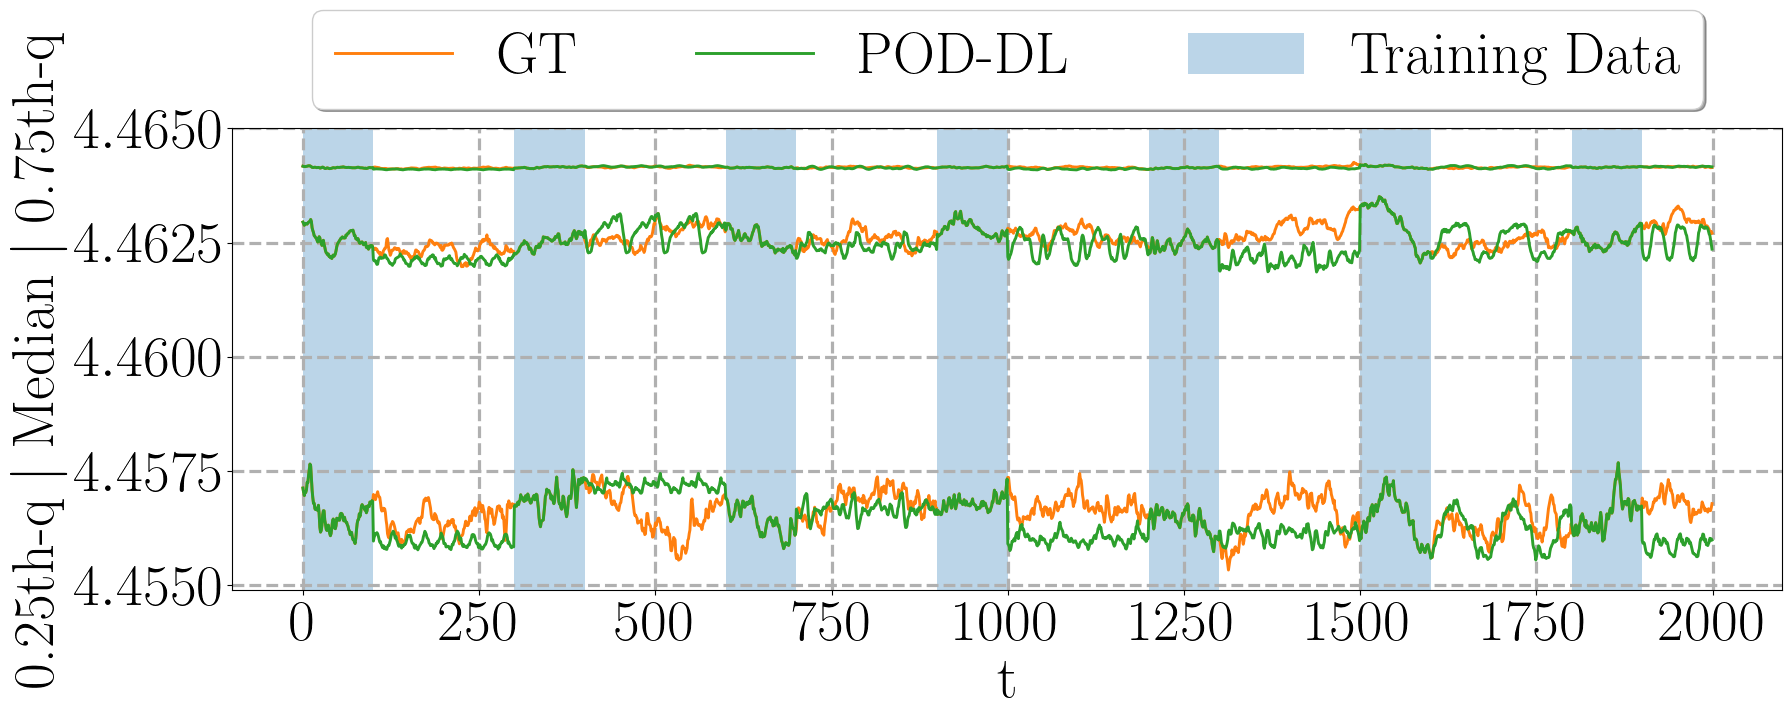

In [14]:
plt.rcParams.update({
    "font.size": 42
})

rc('text', usetex=True)

plt.close('all')
plt.figure(figsize = (20, 6))

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

plt.plot(gt_median, c = colors[1], linewidth = 2.1, label = "GT")
plt.plot(pred_median, c = colors[2], linewidth = 2.1, label = "POD-DL")

plt.plot(gt_75th, '-', c = colors[1], linewidth = 2.1)
plt.plot(pred_75th, '-', c = colors[2], linewidth = 2.1)

plt.plot(gt_25th, '-', c = colors[1], linewidth = 2.1)
plt.plot(pred_25th, '-', c = colors[2], linewidth = 2.1)

plt.grid(True, linestyle = '--', linewidth = 2.3)
plt.xticks([0, 250, 500, 750, 1000, 1250, 1500, 1750, 2000])
plt.yticks([4.455, 4.4575, 4.460, 4.4625, 4.465])

# # S0=100, S1=100, P=2000
# plt.axvspan(0, 100, alpha=0.3, label = "Training Data")

# # S0=100, S1=100, P=600
# plt.axvspan(0, 100, alpha=0.3, label = "Training Data")
# plt.axvspan(700, 800, alpha=0.3)
# plt.axvspan(1400, 1500, alpha=0.3)

# S0=100, S1=100, P=200
plt.axvspan(0, 100, alpha=0.3, label = "Training Data")
plt.axvspan(300, 400, alpha=0.3)
plt.axvspan(600, 700, alpha=0.3)
plt.axvspan(900, 1000, alpha=0.3)
plt.axvspan(1200, 1300, alpha=0.3)
plt.axvspan(1500, 1600, alpha=0.3)
plt.axvspan(1800, 1900, alpha=0.3)

# # S0=100, S1=100, P=50
# plt.axvspan(0, 100, alpha=0.3, label = "Training Data")
# plt.axvspan(200, 250, alpha=0.3)
# plt.axvspan(350, 400, alpha=0.3)
# plt.axvspan(500, 550, alpha=0.3)
# plt.axvspan(650, 700, alpha=0.3)
# plt.axvspan(800, 850, alpha=0.3)
# plt.axvspan(950, 1000, alpha=0.3)
# plt.axvspan(1100, 1150, alpha=0.3)
# plt.axvspan(1250, 1300, alpha=0.3)
# plt.axvspan(1400, 1450, alpha=0.3)
# plt.axvspan(1550, 1600, alpha=0.3)
# plt.axvspan(1700, 1750, alpha=0.3)
# plt.axvspan(1850, 1900, alpha=0.3)

plt.xlabel("t")#, fontsize = 25)
plt.ylabel("0.25th-q $|$ Median $|$ 0.75th-q")#, fontsize = 25)

plt.legend(loc='upper center', bbox_to_anchor = (0.5, 1.32), ncol = 3, fancybox = True, shadow = True)

# Metric 2: Histogram

In [15]:
def compute_hist_mae(err_val, bin_width, gt_ten, pred_ten):

    diff_1 = torch.abs(gt_ten - pred_ten)
    
    if (diff_1.max().abs() <= 1e-8):

        return 1.

    else:
        bin_edges_1 = torch.arange(0.0, diff_1.max() + bin_width, bin_width)

        p_hist_1, _ = torch.histogram(diff_1, bins = bin_edges_1, density = True)

        # bin_width = bin_edges[1] - bin_edges[0]

        p_1 = p_hist_1 * bin_width

        # prob_val = torch.where(bin_edges <= err_val)[0][-1]
        prob_val = int(err_val // bin_width)

        return p_1[:prob_val].sum()

In [16]:
diff_p1 = torch.zeros(recon.shape[-1])
diff_p2 = torch.zeros(recon.shape[-1])

err_val_1 = 1e-2
err_val_2 = 2e-2

for i1 in range(recon.shape[-1]):

    diff_p1[i1] = compute_hist_mae(
        err_val_1,
        1e-5,
        recon[..., i1].flatten(), 
        pred_ten[..., i1].flatten(),
    )

    diff_p2[i1] = compute_hist_mae(
        err_val_2,
        1e-5,
        recon[..., i1].flatten(), 
        pred_ten[..., i1].flatten(),
    )

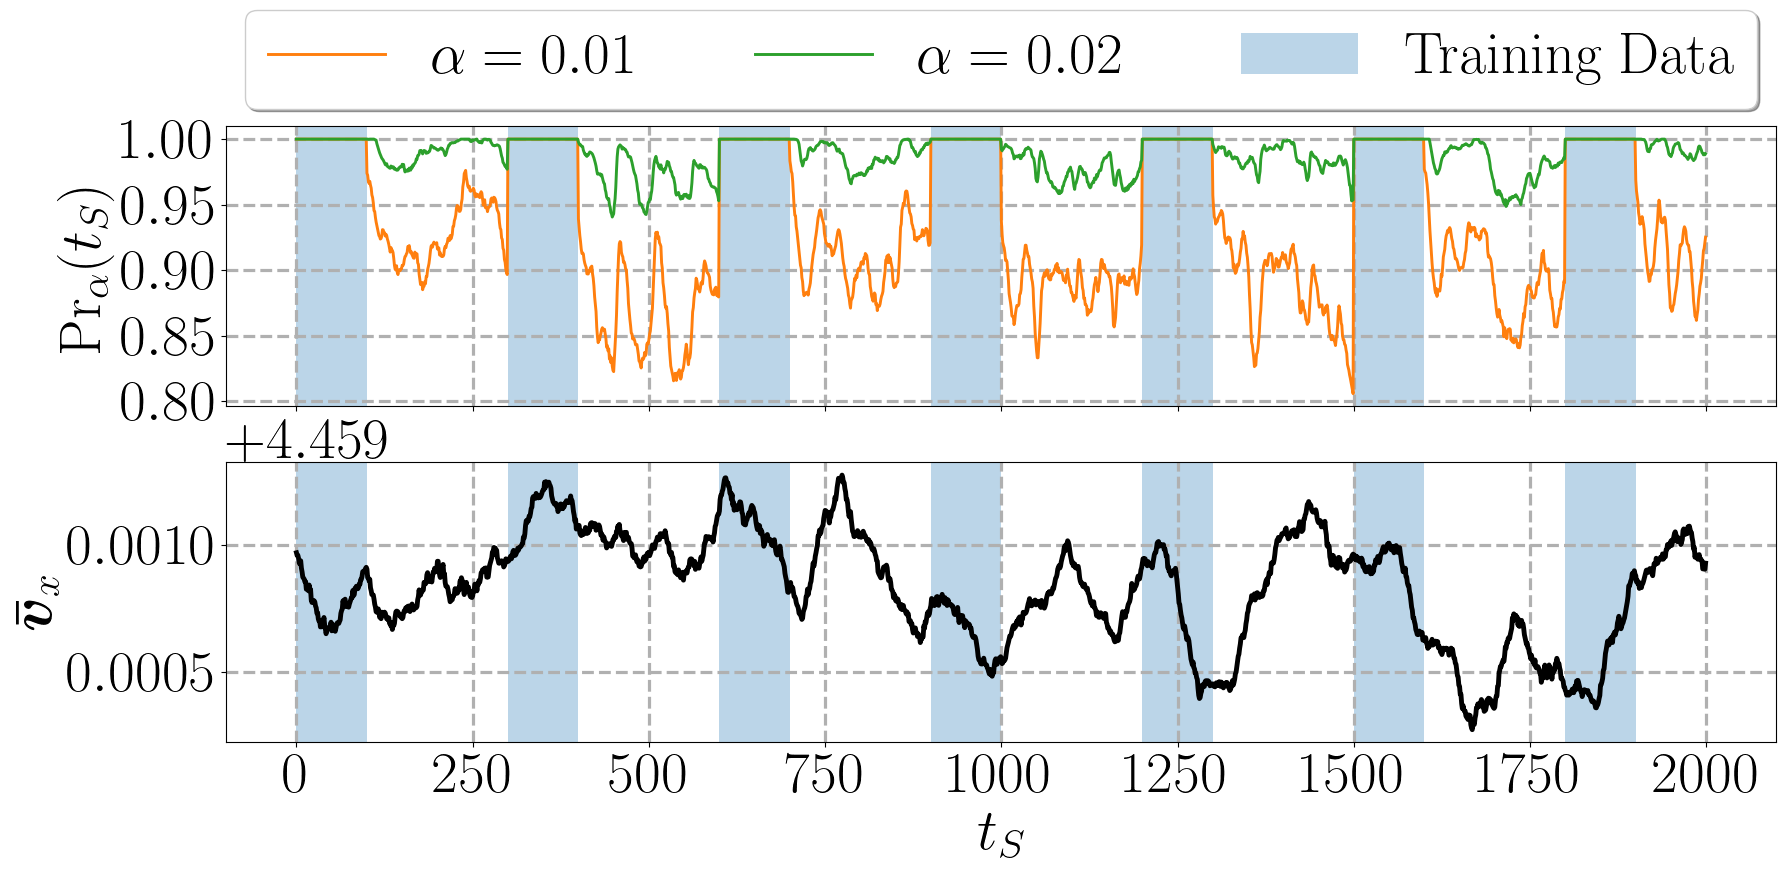

In [17]:
plt.rcParams.update({
    "font.size": 42
})

plt.close('all')

mean_vor = gt_ten[0,...].mean(dim = (0,1))

fig, axs = plt.subplots(2, 1, figsize = (20, 8))

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

axs[0].plot(diff_p1, linewidth = 2.1, label = fr'$\alpha = {err_val_1}$', c = colors[1])
axs[0].plot(diff_p2, linewidth = 2.1, label = fr'$\alpha = {err_val_2}$', c = colors[2])

axs[0].grid(True, linestyle = '--', linewidth = 2.3)
axs[0].set_xticks([0, 250, 500, 750, 1000, 1250, 1500, 1750, 2000])
axs[0].set_yticks([0.8, 0.85, 0.9, 0.95, 1])
axs[0].set_xticklabels([])

axs[1].plot(mean_vor, "k", linewidth = 3.5)
axs[1].grid(True, linestyle = '--', linewidth = 2.3)
axs[1].set_xticks([0, 250, 500, 750, 1000, 1250, 1500, 1750, 2000])
# axs[1].set_yticks([4.459 + 0, 4.459 + 0.0005, 4.459 + 0.001])
axs[1].set_ylabel(r"$\boldsymbol{\bar{v}}_{x}$")
axs[1].set_xlabel(r"$t_{S}$")

# # S0=100, S1=100, P=2000
# axs[0].axvspan(0, 100, alpha=0.3, label = "Training Data")
# axs[1].axvspan(0, 100, alpha=0.3, label = "Training Data")

# # S0=100, S1=100, P=2000
# axs[0].axvspan(0, 100, alpha=0.3, label = "Training Data")
# axs[0].axvspan(700, 800, alpha=0.3)
# axs[0].axvspan(1400, 1500, alpha=0.3)
# axs[1].axvspan(0, 100, alpha=0.3)
# axs[1].axvspan(700, 800, alpha=0.3)
# axs[1].axvspan(1400, 1500, alpha=0.3)

# S0=100, S1=100, P=200
axs[0].axvspan(0, 100, alpha=0.3, label = "Training Data")
axs[0].axvspan(300, 400, alpha=0.3)
axs[0].axvspan(600, 700, alpha=0.3)
axs[0].axvspan(900, 1000, alpha=0.3)
axs[0].axvspan(1200, 1300, alpha=0.3)
axs[0].axvspan(1500, 1600, alpha=0.3)
axs[0].axvspan(1800, 1900, alpha=0.3)
axs[1].axvspan(0, 100, alpha=0.3)
axs[1].axvspan(300, 400, alpha=0.3)
axs[1].axvspan(600, 700, alpha=0.3)
axs[1].axvspan(900, 1000, alpha=0.3)
axs[1].axvspan(1200, 1300, alpha=0.3)
axs[1].axvspan(1500, 1600, alpha=0.3)
axs[1].axvspan(1800, 1900, alpha=0.3)

# # S0=200, S1=100, P=50
# axs[0].axvspan(0, 100, alpha=0.3, label = "Training Data")
# axs[0].axvspan(200, 250, alpha=0.3)
# axs[0].axvspan(350, 400, alpha=0.3)
# axs[0].axvspan(500, 550, alpha=0.3)
# axs[0].axvspan(650, 700, alpha=0.3)
# axs[0].axvspan(800, 850, alpha=0.3)
# axs[0].axvspan(950, 1000, alpha=0.3)
# axs[0].axvspan(1100, 1150, alpha=0.3)
# axs[0].axvspan(1250, 1300, alpha=0.3)
# axs[0].axvspan(1400, 1450, alpha=0.3)
# axs[0].axvspan(1550, 1600, alpha=0.3)
# axs[0].axvspan(1700, 1750, alpha=0.3)
# axs[0].axvspan(1850, 1900, alpha=0.3)
# axs[1].axvspan(0, 100, alpha=0.3)
# axs[1].axvspan(200, 250, alpha=0.3)
# axs[1].axvspan(350, 400, alpha=0.3)
# axs[1].axvspan(500, 550, alpha=0.3)
# axs[1].axvspan(650, 700, alpha=0.3)
# axs[1].axvspan(800, 850, alpha=0.3)
# axs[1].axvspan(950, 1000, alpha=0.3)
# axs[1].axvspan(1100, 1150, alpha=0.3)
# axs[1].axvspan(1250, 1300, alpha=0.3)
# axs[1].axvspan(1400, 1450, alpha=0.3)
# axs[1].axvspan(1550, 1600, alpha=0.3)
# axs[1].axvspan(1700, 1750, alpha=0.3)
# axs[1].axvspan(1850, 1900, alpha=0.3)

axs[1].set_xlabel(r"$t_{S}$")
axs[0].set_ylabel(r"$\text{Pr}_{\alpha}(t_{S})$")

axs[0].legend(loc='upper center', bbox_to_anchor = (0.5, 1.52), ncol = 4, fancybox = True, shadow = True)